In [1]:
import pandas as pd
import numpy as np

from utils import column_name_mapping

In [2]:
df = pd.read_csv('data/Case Rigshospitalet.csv')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3060\4698354.py:1: DtypeWarning: Columns (9,13,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Case Rigshospitalet.csv')


In [3]:
df.columns

Index(['Patient ID', 'Patientkontakt ID',
       'Patient alder på kontaktstart tidspunkt', 'Kontakt startdato',
       'Kontakt slutdato', 'Kontakttype', 'Indlæggelsesmåde',
       'Patientkontakttype', 'Aktionsdiagnosekode', 'Bidiagnosekode',
       'Behandlingsansvarlig Afdeling', 'Kontakt varighed (timer)',
       'Procedure-kode', 'Procedure-tillægskoder', 'Procedure udført',
       'Behandlingskontakt ID', 'Besøgstype', 'Patient køn',
       'Patient civilstand', 'Patient oprettet på Min SP (J/N)',
       'Patient land', 'Patient region', 'Patient postnummer',
       'Patient kommune'],
      dtype='object')

In [4]:
# renaming columns to english
df = df.rename(columns=column_name_mapping)

In [5]:
df.columns

Index(['patientID', 'patientContactID', 'patientAgeAtContactStart',
       'contactStartDate', 'contactEndDate', 'contactType',
       'appointmentUrgency', 'patientContactType', 'primaryDiagnosisCode',
       'secondaryDiagnosisCode', 'responsibleDepartment',
       'contactDurationHours', 'procedureCode', 'procedureSupplementaryCodes',
       'procedurePerformed', 'treatmentContactID', 'visitType',
       'patientGender', 'patientMaritalStatus', 'patientRegisteredInMySP',
       'patientCountry', 'patientRegion', 'patientPostalCode',
       'patientMunicipality'],
      dtype='object')

In [6]:
# procedureSupplementaryCodes and visitType have to many missing values
# rest does not seem useful (at least for now)
drop_columns = ['responsibleDepartment', 'secondaryDiagnosisCode', 'procedureSupplementaryCodes', 
                'visitType', 'patientRegisteredInMySP', 'patientCountry', 'patientRegion',
                'patientPostalCode', 'patientMunicipality','patientMaritalStatus','procedurePerformed',
                'contactDurationHours']

In [7]:
# filtering out missing patientID (46 cases) and droping redundant columns
df_cleaned = df.copy()
df_cleaned = df_cleaned[~df_cleaned['patientID'].isnull()].drop(columns=drop_columns)

In [8]:
df_cleaned.columns

Index(['patientID', 'patientContactID', 'patientAgeAtContactStart',
       'contactStartDate', 'contactEndDate', 'contactType',
       'appointmentUrgency', 'patientContactType', 'primaryDiagnosisCode',
       'procedureCode', 'treatmentContactID', 'patientGender'],
      dtype='object')

In [9]:
# converting to datetime
df_cleaned['contactStartDate'] = df_cleaned['contactStartDate'].str.replace(',', '.')
df_cleaned['contactEndDate'] = df_cleaned['contactEndDate'].str.replace(',', '.')

df_cleaned['contactStartDate'] = pd.to_datetime(df_cleaned['contactStartDate'])
df_cleaned['contactEndDate'] = pd.to_datetime(df_cleaned['contactEndDate'])

df_cleaned['contactDurationMin'] = (df_cleaned['contactEndDate'] - df_cleaned['contactStartDate']).dt.total_seconds() / 60

In [10]:
# few patient level columns at this stage (passed later to df_patient)
df_cleaned['numVisits'] = df_cleaned.groupby('patientID')['patientContactID'].transform('nunique')
df_cleaned['numProcedures'] = df_cleaned.groupby('patientID')['procedureCode'].transform('nunique')
df_cleaned['numContacts'] = df_cleaned.groupby('patientID')['treatmentContactID'].transform('nunique')

In [11]:
# deduplicate appointments at this point to ease further calculations
df_appointments = df_cleaned.drop_duplicates(subset='patientContactID', keep='first')
print('Num of rows/appointments after dedup: ', len(df_appointments))
df_appointments.head()

Num of rows/appointments after dedup:  1821183


,patientID,patientContactID,patientAgeAtContactStart,contactStartDate,contactEndDate,contactType,appointmentUrgency,patientContactType,primaryDiagnosisCode,procedureCode,treatmentContactID,patientGender,contactDurationMin,numVisits,numProcedures,numContacts
0,Z4115614,1301023075465,0,2023-01-13 12:32:00,2023-01-13 13:02:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,ZZ0151,176.794.528,Mand,30.0,6,6,6
1,Z4115614,1301023121831,0,2023-01-15 13:27:00,2023-01-15 13:57:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,ZZ0151,177.035.032,Mand,30.0,6,6,6
2,Z4119225,1301023357249,0,2023-01-30 10:20:00,2023-01-30 10:50:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,ZZ0151,178.269.449,Mand,30.0,6,3,6
3,Z4127033,1301023443807,0,2023-02-04 12:46:00,2023-02-04 13:16:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,ZZ0151,178.703.583,Mand,30.0,17,11,17
4,Z4127033,1301023443875,0,2023-02-05 12:22:00,2023-02-05 12:52:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,ZZ0151,178.703.779,Mand,30.0,17,11,17


In [12]:
df_appointments['cumulativeVisitDuration'] = df_appointments.groupby(['patientID'])['contactDurationMin'].transform('sum')
df_appointments['Age'] = df_appointments.groupby(['patientID'])['patientAgeAtContactStart'].transform('mean')
df_appointments['Gender'] = df_appointments['patientGender'].map({'Kvinde': 0}).fillna(1)

# wrapping diagnosis into set for each patient
diagnosis_set = df_appointments.groupby('patientID')['primaryDiagnosisCode'].agg(set).reset_index()
df_appointments = df_appointments.merge(diagnosis_set, on='patientID', how='left', suffixes=('', '_unique'))
df_appointments.rename(columns={'primaryDiagnosisCode_unique': 'Diagnosis'}, inplace=True)

# calculate number of contact types per patient
df_contact_counts = pd.crosstab(df_appointments['patientID'], df_appointments['contactType'])
df_contact_counts.columns = [f'num_{contact_type}' for contact_type in df_contact_counts.columns]
df_appointments = df_appointments.merge(df_contact_counts, on='patientID', how='left')

# calculate number of contact types per patient
df_urgency_counts = pd.crosstab(df_appointments['patientID'], df_appointments['appointmentUrgency'])
df_urgency_counts.columns = [f'num_{urgency_type}' for urgency_type in df_urgency_counts.columns]
df_appointments = df_appointments.merge(df_urgency_counts, on='patientID', how='left')

# calculate number of patient contact types per patient
df_patient_contact_type_counts = pd.crosstab(df_appointments['patientID'], df_appointments['patientContactType'])
df_patient_contact_type_counts.columns = [f'num_{patient_contact_type}' for patient_contact_type in df_patient_contact_type_counts.columns]
df_appointments = df_appointments.merge(df_patient_contact_type_counts, on='patientID', how='left')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3060\197153596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appointments['cumulativeVisitDuration'] = df_appointments.groupby(['patientID'])['contactDurationMin'].transform('sum')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3060\197153596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appointments['Age'] = df_appointments.groupby(['patientID'])['patientAgeAtContactStart'].transform('mean')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3060\19

In [13]:
#diagnosis_set = df_appointments.groupby('patientID')['primaryDiagnosisCode'].agg(set).reset_index()
#df_appointments = df_appointments.merge(diagnosis_set, on='patientID', how='left', suffixes=('', '_unique'))
#df_appointments.rename(columns={'primaryDiagnosisCode_unique': 'Diagnosis'}, inplace=True)

In [14]:
rename_columns = {
'num_Fysisk fremmøde':'PhysicalAppointments',
'num_Udekontakt':'HomeAppointments',
'num_Virtuel pt.kt.':'VirtualAppointments',
'num_2 Ambulant':'numRegularOutpatient',
'num_3 Akut Ambulant':'numAcuteAmbulatory',
'num_4 Ambulant Us/Op':'numUnderObservation',
'num_Akut':'numAcute',
'num_Planlagt':'numPlanned'
}

df_appointments = df_appointments.rename(columns=rename_columns)

In [15]:
df_appointments.columns

Index(['patientID', 'patientContactID', 'patientAgeAtContactStart',
       'contactStartDate', 'contactEndDate', 'contactType',
       'appointmentUrgency', 'patientContactType', 'primaryDiagnosisCode',
       'procedureCode', 'treatmentContactID', 'patientGender',
       'contactDurationMin', 'numVisits', 'numProcedures', 'numContacts',
       'cumulativeVisitDuration', 'Age', 'Gender', 'Diagnosis',
       'PhysicalAppointments', 'HomeAppointments', 'VirtualAppointments',
       'numAcute', 'numPlanned', 'numRegularOutpatient', 'numAcuteAmbulatory',
       'numUnderObservation'],
      dtype='object')

In [16]:
patient_columns = [
    'patientID', 'numVisits', 'numProcedures', 'numContacts',
    'cumulativeVisitDuration', 'Age', 'Gender', 'Diagnosis',
    'PhysicalAppointments', 'HomeAppointments', 'VirtualAppointments',
    'numAcute', 'numPlanned', 'numRegularOutpatient', 'numAcuteAmbulatory',
    'numUnderObservation'
]

df_patient = df_appointments[patient_columns]

In [17]:
df_patient = df_patient.drop_duplicates(subset='patientID', keep='first')
print('Num of rows/appointments after dedup: ', len(df_patient))
df_patient.head()

Num of rows/appointments after dedup:  331762


,patientID,numVisits,numProcedures,numContacts,cumulativeVisitDuration,Age,Gender,Diagnosis,PhysicalAppointments,HomeAppointments,VirtualAppointments,numAcute,numPlanned,numRegularOutpatient,numAcuteAmbulatory,numUnderObservation
0,Z4115614,6,6,6,342.0,0.0,1.0,"{DQ549, DQ540, DZ001}",5,0,1,0,6,6,0,0
2,Z4119225,6,3,6,260.0,0.0,1.0,{DZ001},6,0,0,0,6,6,0,0
3,Z4127033,17,11,17,1547.0,0.0,1.0,"{DZ135C, DK628, DZ033A, DQ753, DZ001, DP599}",14,1,2,0,17,17,0,0
5,Z4139519,3,3,3,120.0,0.0,1.0,{DZ001},3,0,0,0,3,3,0,0
7,Z4146746,4,3,4,180.0,0.0,1.0,{DZ001},3,1,0,0,4,4,0,0


In [18]:
# save to csv
df_patient.to_csv('data/patient_dataframe.csv', index=False)

In [19]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331762 entries, 0 to 1821136
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientID                331762 non-null  object 
 1   numVisits                331762 non-null  int64  
 2   numProcedures            331762 non-null  int64  
 3   numContacts              331762 non-null  int64  
 4   cumulativeVisitDuration  331762 non-null  float64
 5   Age                      331762 non-null  float64
 6   Gender                   331762 non-null  float64
 7   Diagnosis                331762 non-null  object 
 8   PhysicalAppointments     331762 non-null  int64  
 9   HomeAppointments         331762 non-null  int64  
 10  VirtualAppointments      331762 non-null  int64  
 11  numAcute                 331762 non-null  int64  
 12  numPlanned               331762 non-null  int64  
 13  numRegularOutpatient     331762 non-null  int64  
 14  numAcute

In [20]:
df_patient.head()

,patientID,numVisits,numProcedures,numContacts,cumulativeVisitDuration,Age,Gender,Diagnosis,PhysicalAppointments,HomeAppointments,VirtualAppointments,numAcute,numPlanned,numRegularOutpatient,numAcuteAmbulatory,numUnderObservation
0,Z4115614,6,6,6,342.0,0.0,1.0,"{DQ549, DQ540, DZ001}",5,0,1,0,6,6,0,0
2,Z4119225,6,3,6,260.0,0.0,1.0,{DZ001},6,0,0,0,6,6,0,0
3,Z4127033,17,11,17,1547.0,0.0,1.0,"{DZ135C, DK628, DZ033A, DQ753, DZ001, DP599}",14,1,2,0,17,17,0,0
5,Z4139519,3,3,3,120.0,0.0,1.0,{DZ001},3,0,0,0,3,3,0,0
7,Z4146746,4,3,4,180.0,0.0,1.0,{DZ001},3,1,0,0,4,4,0,0


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

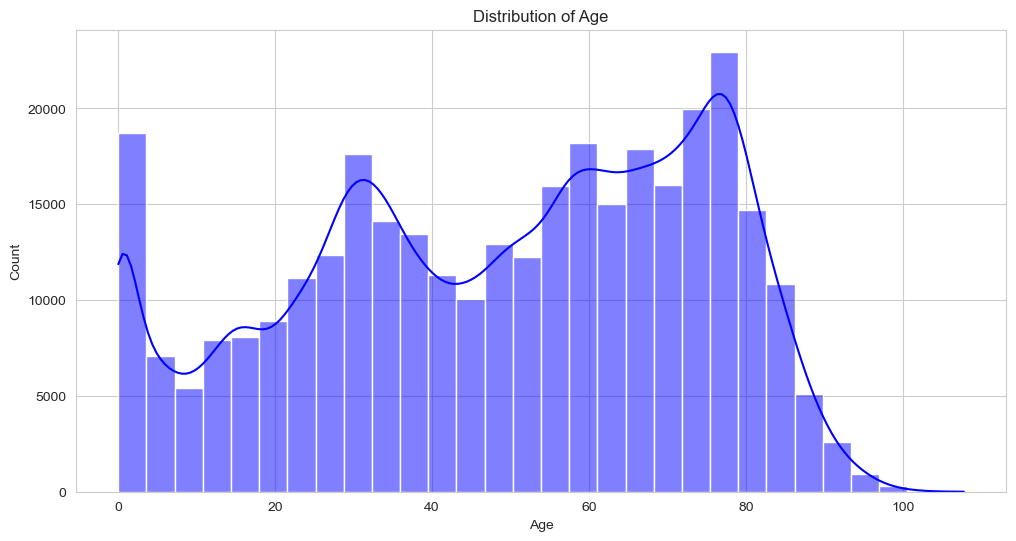

In [22]:
df = df_patient.copy()

# Set style
sns.set_style("whitegrid")

# Distribution of Age
plt.figure(figsize=(12, 6))
sns.histplot(df['Age'], bins=30, kde=True, color='blue')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

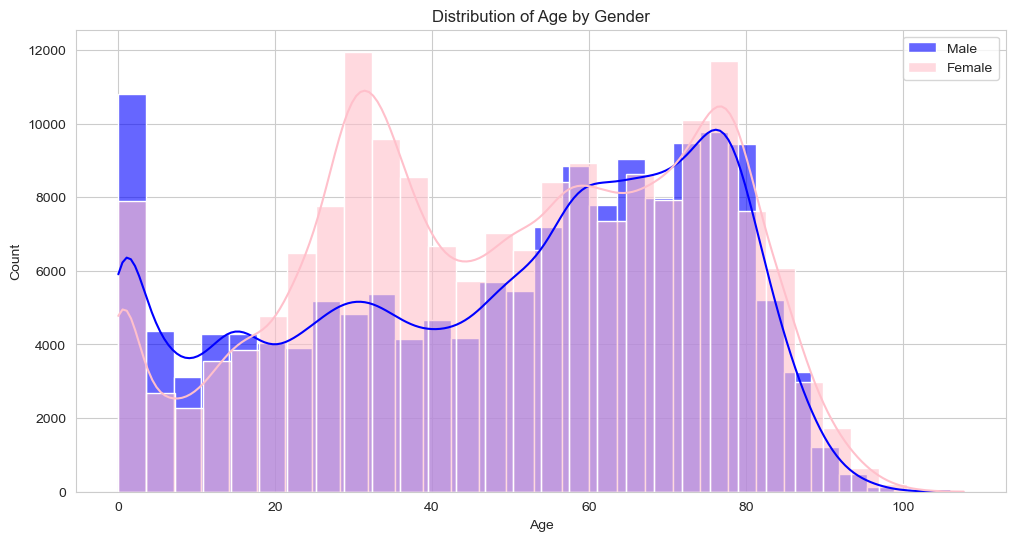

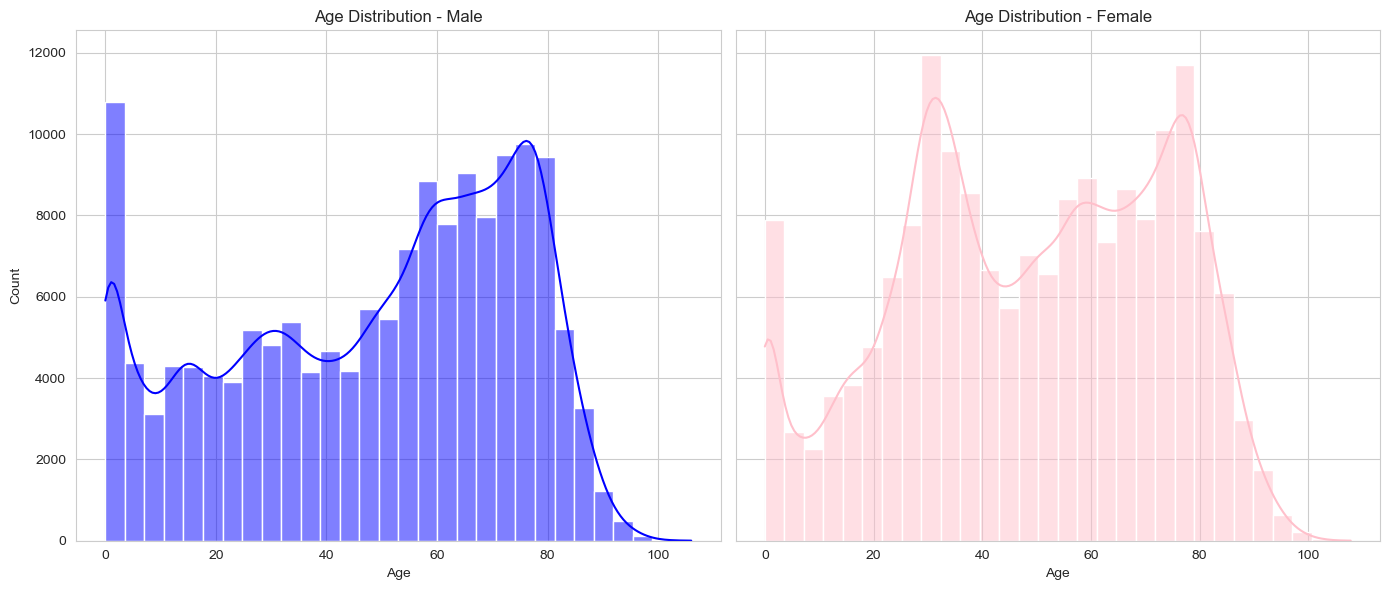

In [23]:
# Distribution of Age by Gender
plt.figure(figsize=(12, 6))
sns.histplot(df_patient[df_patient['Gender'] == 1]['Age'], bins=30, kde=True, color='blue', label='Male', alpha=0.6)
sns.histplot(df_patient[df_patient['Gender'] == 0]['Age'], bins=30, kde=True, color='pink', label='Female', alpha=0.6)
plt.title("Distribution of Age by Gender")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

# Separate Plots for Males and Females
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.histplot(df_patient[df_patient['Gender'] == 1]['Age'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Age Distribution - Male")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

sns.histplot(df_patient[df_patient['Gender'] == 0]['Age'], bins=30, kde=True, color='pink', ax=axes[1])
axes[1].set_title("Age Distribution - Female")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3060\2857216844.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Gender'].astype(str), palette='coolwarm')


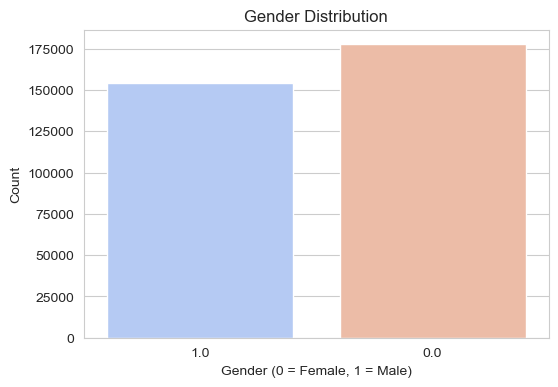

In [24]:
#Geneder distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Gender'].astype(str), palette='coolwarm')
plt.title("Gender Distribution")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Count")
plt.show()

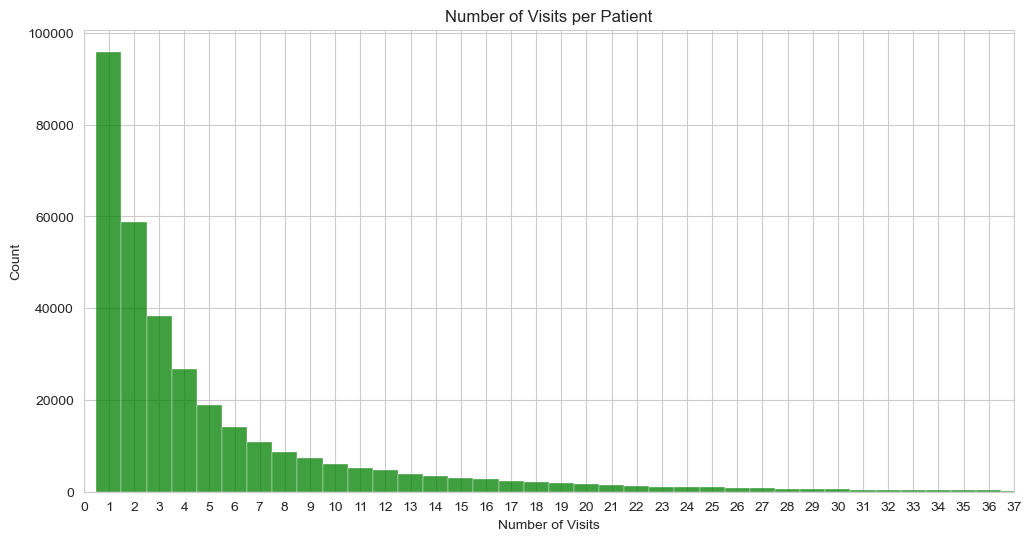

In [25]:
# Number of Visits per Patient
plt.figure(figsize=(12, 6))
sns.histplot(df_patient['numVisits'], bins=int(df_patient['numVisits'].max()), kde=False, color='green', discrete=True)
plt.title("Number of Visits per Patient")
plt.xlabel("Number of Visits")
plt.ylabel("Count")
plt.xlim(0, df_patient['numVisits'].quantile(0.99))  # Remove outliers
plt.xticks(range(0, int(df_patient['numVisits'].quantile(0.99)) + 1, 1))  # Ensure x-axis shows every integer count
plt.show()


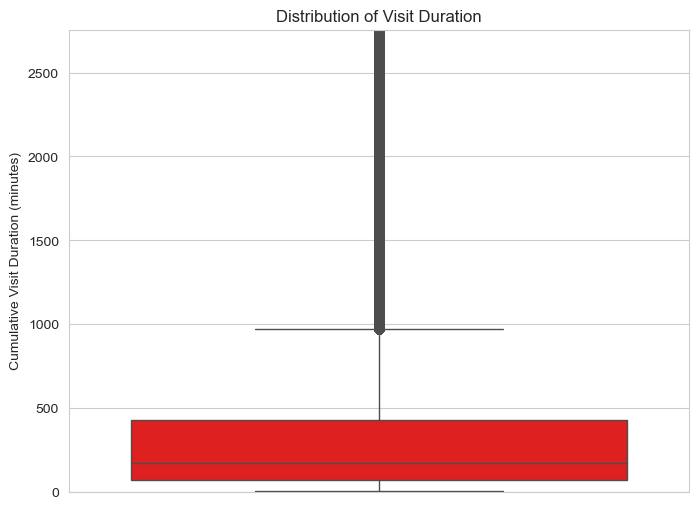

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['cumulativeVisitDuration'], color='red')
plt.title("Distribution of Visit Duration")
plt.ylabel("Cumulative Visit Duration (minutes)")
plt.ylim(0, df['cumulativeVisitDuration'].quantile(0.99))  # Remove outliers
plt.show()

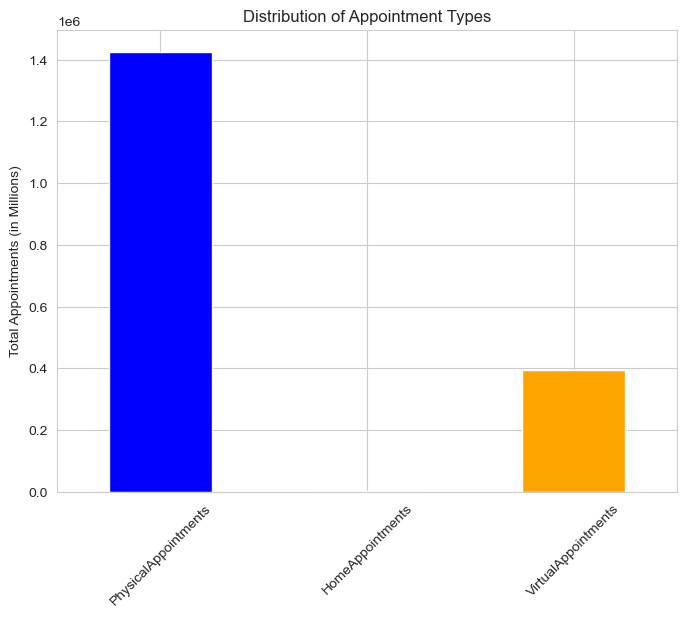

In [27]:
#Appointment Patterns
appointment_types = ['PhysicalAppointments', 'HomeAppointments', 'VirtualAppointments']
df[appointment_types].sum().plot(kind='bar', figsize=(8, 6), color=['blue', 'green', 'orange'])
plt.title("Distribution of Appointment Types")
plt.ylabel("Total Appointments (in Millions)")
plt.xticks(rotation=45)
plt.show()

In [28]:
# Check the count of HomeAppointments
home_appointments_count = df_patient['HomeAppointments'].sum()
print(f"Total Home Appointments: {home_appointments_count}")

Total Home Appointments: 2549


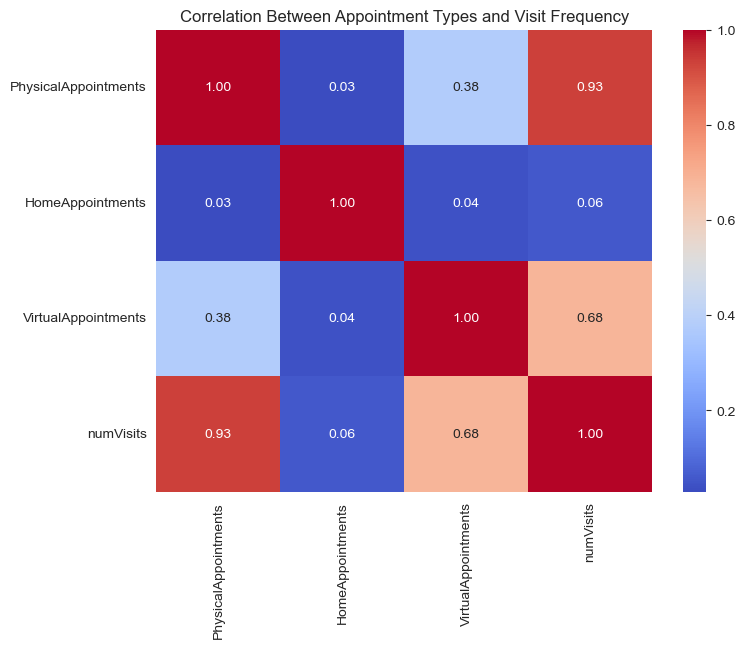

In [29]:
# Correlation between appointment type and numVisits
plt.figure(figsize=(8, 6))
sns.heatmap(df[appointment_types + ['numVisits']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Appointment Types and Visit Frequency")
plt.show()

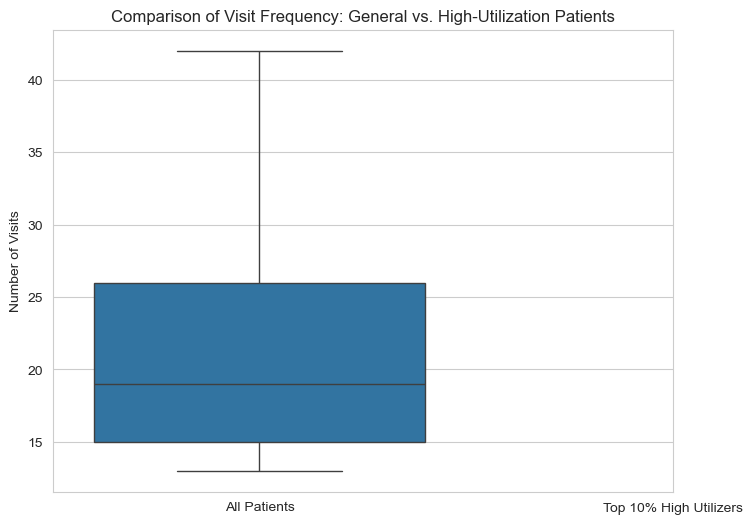

In [30]:
#High-Utilization Patients
threshold = df['numVisits'].quantile(0.90)  # Top 10% patients
high_utilization = df[df['numVisits'] >= threshold]

plt.figure(figsize=(8, 6))
sns.boxplot(data=[df['numVisits'], high_utilization['numVisits']], showfliers=False)
plt.xticks([0, 1], ["All Patients", "Top 10% High Utilizers"])
plt.title("Comparison of Visit Frequency: General vs. High-Utilization Patients")
plt.ylabel("Number of Visits")
plt.show()

In [31]:
# Load diagnosis dimension table
df_diagnosis = pd.read_csv('data/Diagnosis dimension table.csv', delimiter=";")

In [32]:
df_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Aktionsdiagnosekode   19482 non-null  object
 1   Aktionsdiagnosetekst  19482 non-null  object
 2   Gruppe 3              19481 non-null  object
 3   Gruppe 2              19482 non-null  object
 4   Gruppe 1              19482 non-null  object
dtypes: object(5)
memory usage: 761.1+ KB


In [33]:
df_diagnosis.head()

,Aktionsdiagnosekode,Aktionsdiagnosetekst,Gruppe 3,Gruppe 2,Gruppe 1
0,DA00,Kolera,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme
1,DA000,Kolera forårsaget af Vibrio cholerae,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme
2,DA001,Kolera forårsaget af Vibrio cholerae eltor,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme
3,DA009,Kolera UNS,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme
4,DA01,Tyfus og paratyfus,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme


In [34]:
# Rename columns in df_diagnosis for consistency
df_diagnosis.rename(columns={"Aktionsdiagnosekode": "Diagnosis", "Aktionsdiagnosetekst": "Disease Name"}, inplace=True)

# Ensure Diagnosis column is in the correct format in df_patient
df_patient['Diagnosis'] = df_patient['Diagnosis'].apply(lambda x: list(eval(x)) if isinstance(x, str) else x)

# Explode df_patient so each row has only one diagnosis
df_patient = df_patient.explode('Diagnosis')

# Merge df_patient with df_diagnosis to add all available diagnosis information
df_patient = df_patient.merge(df_diagnosis, on="Diagnosis", how="left")


In [35]:
# Revert the explode operation: aggregate Diagnosis and Disease Name back into lists
df_patient = df_patient.groupby('patientID').agg({
    'numVisits': 'sum',
    'numProcedures': 'sum',
    'numContacts': 'sum',
    'cumulativeVisitDuration': 'sum',
    'Age': 'first',
    'Gender': 'first',
    'Diagnosis': lambda x: list(set(x.dropna())),  # Convert back to list format
    'PhysicalAppointments': 'sum',
    'HomeAppointments': 'sum',
    'VirtualAppointments': 'sum',
    'numAcute': 'sum',
    'numPlanned': 'sum',
    'numRegularOutpatient': 'sum',
    'numAcuteAmbulatory': 'sum',
    'numUnderObservation': 'sum',
    'Disease Name': lambda x: list(set(x.dropna())),  # Convert back to list format
    'Gruppe 3': lambda x: list(set(x.dropna())),
    'Gruppe 2': lambda x: list(set(x.dropna())),
    'Gruppe 1': lambda x: list(set(x.dropna()))
}).reset_index()

In [36]:
df_patient.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331762 entries, 0 to 331761
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientID                331762 non-null  object 
 1   numVisits                331762 non-null  int64  
 2   numProcedures            331762 non-null  int64  
 3   numContacts              331762 non-null  int64  
 4   cumulativeVisitDuration  331762 non-null  float64
 5   Age                      331762 non-null  float64
 6   Gender                   331762 non-null  float64
 7   Diagnosis                331762 non-null  object 
 8   PhysicalAppointments     331762 non-null  int64  
 9   HomeAppointments         331762 non-null  int64  
 10  VirtualAppointments      331762 non-null  int64  
 11  numAcute                 331762 non-null  int64  
 12  numPlanned               331762 non-null  int64  
 13  numRegularOutpatient     331762 non-null  int64  
 14  numA